In [323]:
!pip install ipython-autotime --quiet
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 3.24 s (started: 2021-12-10 13:26:27 +00:00)


In [324]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from google.colab.patches import cv2_imshow
import glob
import os

import tensorflow
from tensorflow.keras import layers, models
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16

time: 4.09 ms (started: 2021-12-10 13:26:30 +00:00)


In [325]:
from google.colab import drive
drive.mount('/content/data')

Drive already mounted at /content/data; to attempt to forcibly remount, call drive.mount("/content/data", force_remount=True).
time: 3 s (started: 2021-12-10 13:26:30 +00:00)


In [326]:
TRAIN_IMAGE_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Train Images"
TEST_IMAGE_PATH = "/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car Images/Test Images"

time: 1.42 ms (started: 2021-12-10 13:26:33 +00:00)


In [327]:
df_train_annotations = pd.read_csv('/content/data/MyDrive/ColabNotebooks/CapstoneProject/Annotations/Train Annotations.csv')
df_test_annotations = pd.read_csv('/content/data/MyDrive/ColabNotebooks/CapstoneProject/Annotations/Test Annotation.csv')

time: 29.5 ms (started: 2021-12-10 13:26:33 +00:00)


In [328]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNEL = 3

time: 1.65 ms (started: 2021-12-10 13:26:33 +00:00)


In [329]:
df_train_annotations.head()

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106


time: 20.1 ms (started: 2021-12-10 13:26:33 +00:00)


The bounding box coordinates are not clearly labelled. It could be either in (xmin, ymin, xmax, ymax) format or (x, y, width, height) format. First, I will assume that the coordinates are in (xmin, ymin, xmax, ymax) format and change the columns names accordingly.

In [330]:
def rename_columns(annotation_data):
  annotation_data.rename(columns = {'Bounding Box coordinates':'xmin'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 2':'ymin'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 3':'xmax'}, inplace = True)
  annotation_data.rename(columns = {'Unnamed: 4':'ymax'}, inplace = True)
  annotation_data.rename(columns = {'Image class':'image_class'}, inplace = True)
  annotation_data.rename(columns = {'Image Name':'image_name'}, inplace = True)
  return annotation_data

time: 3.77 ms (started: 2021-12-10 13:26:33 +00:00)


In [331]:
# Changing column names of train and test annotations
df_train_annotations = rename_columns(df_train_annotations)
df_test_annotations = rename_columns(df_test_annotations)

time: 7.74 ms (started: 2021-12-10 13:26:33 +00:00)


In the training set there are 196 unique classes i.e. 196 different makes of cars

In [332]:
len(df_train_annotations['image_class'].unique())

196

time: 4.15 ms (started: 2021-12-10 13:26:33 +00:00)


In [333]:
#Loading name of cars 
df_carnames = pd.read_csv("/content/data/MyDrive/ColabNotebooks/CapstoneProject/Car names and make.csv",header=None)

time: 5.93 ms (started: 2021-12-10 13:26:33 +00:00)


The number of car names match the number of unique make of cars in the training annotations file

In [334]:
df_carnames.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196 entries, 0 to 195
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       196 non-null    object
dtypes: object(1)
memory usage: 1.7+ KB
time: 7.61 ms (started: 2021-12-10 13:26:33 +00:00)


In [335]:
df_carnames.head()

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


time: 9.27 ms (started: 2021-12-10 13:26:33 +00:00)


In [336]:
# Method to verify the whether the bounding box coordinates are fitting correctly
def show_image_with_bounding_box(image_name):
  image_path = glob.glob(TRAIN_IMAGE_PATH+"/**/"+image_name, recursive = True)
  annotation = df_train_annotations[df_train_annotations["image_name"] == image_name]

  #Set bounding box coordinates as tuple
  start_point = (annotation.xmin, annotation.ymin) 
  end_point = (annotation.xmax, annotation.ymax)

  # Blue color in BGR 
  color = (255, 0, 0) 
    
  # Line thickness of 2 px 
  thickness = 1
  
  #read image using cv2
  image = cv2.imread(image_path[0])

  # Using cv2.rectangle() method 
  # Draw a rectangle with blue line borders of thickness of 2 px 
  image = cv2.rectangle(image, start_point, end_point, color, thickness)

  #Show the image with matplotlib
  plt.imshow(image)
  plt.show()

time: 11.5 ms (started: 2021-12-10 13:26:33 +00:00)


The below sample images confirm that the bounding box coordinates are in (xmin, ymin, xmax, ymax) format

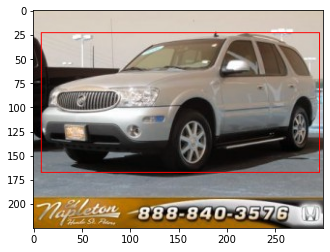

time: 579 ms (started: 2021-12-10 13:26:34 +00:00)


In [337]:
# Sample image with bounding box
show_image_with_bounding_box("00487.jpg")

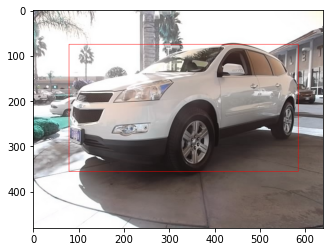

time: 635 ms (started: 2021-12-10 13:26:35 +00:00)


In [338]:
# Sample image with bounding box
show_image_with_bounding_box("00999.jpg")

Checking whether the number of images in train and test set match against the number of annotations in train and test.

There are 8144 annotations in training set and 8041 annotations in test set.

In [339]:
print(df_train_annotations.shape)
print(df_test_annotations.shape)

(8144, 6)
(8041, 6)
time: 1.43 ms (started: 2021-12-10 13:26:36 +00:00)


Number of images in Training set matches the number of annotations i.e. 8144 and all the images in traning set are "jpg" images.

In [340]:
image_path = glob.glob(TRAIN_IMAGE_PATH+"/**/*.jpg", recursive = True)
len(image_path)

8144

time: 468 ms (started: 2021-12-10 13:26:37 +00:00)


Number of images in Test set matches the number of annotations i.e. 8041 and all the images in traning set are "jpg" images.

In [341]:
image_path = glob.glob(TEST_IMAGE_PATH+"/**/*.jpg", recursive = True)
len(image_path)

8041

time: 458 ms (started: 2021-12-10 13:26:38 +00:00)


Creating an image dataframe that contains image details

In [342]:
def createImageDF(imageSourceFolder,target_size_tuple,colormode,totalImagePerClassCap):
    dfRows=[]
    for dirname, _, filenames in os.walk(imageSourceFolder):
            limit=0
            if len(filenames) < totalImagePerClassCap or totalImagePerClassCap == 0:
                limit=len(filenames)
            else:
                limit=totalImagePerClassCap
            for i in range(0,limit):
                    processedRows=[]
                    filename=filenames[i]
                    if filename == ".DS_Store":
                      continue
                    #print('filename: ', filename)
                    processedRows.append(filename)
                    pathSplits=dirname.split('/')
                    #print(os.path.join(dirname, filename))
                    imgPath=os.path.join(dirname, filename)
                    #print(imgPath)
                    img = image.load_img(imgPath)
                    if target_size_tuple!='':
                        img_scaled = image.load_img(imgPath, target_size=target_size_tuple, color_mode = colormode)
                        image_width = img.width
                        image_height = img.height
                        image_width_scale_fact=target_size_tuple[0]/img.width
                        image_height_scale_fact=target_size_tuple[1]/img.height
                        imgArray = image.img_to_array(img_scaled)
                    else:
                        img
                        image_width = img.width
                        image_height = img.height                        
                        image_width_scale_fact=img.width
                        image_height_scale_fact=img.height
                        #img = Image.open(imgPath)
                        imgArray = image.img_to_array(img)
                    #imgArray=np.asarray(img)
                    processedRows.append(imgArray)
                    processedRows.append(pathSplits[len(pathSplits)-1])
                    processedRows.append(image_width)
                    processedRows.append(image_height)                   
                    processedRows.append(image_width_scale_fact)
                    processedRows.append(image_height_scale_fact)
                    dfRows.append(processedRows)
    return pd.DataFrame(dfRows, columns=["image_name","image_array","model","image_width","image_height","image_width_scale_fact","image_height_scale_fact"])

time: 36.1 ms (started: 2021-12-10 13:26:39 +00:00)


In [343]:
# This creates a dataframe with resized image of size (224, 224, 3)
df_train_224 = createImageDF(TRAIN_IMAGE_PATH,(IMAGE_WIDTH, IMAGE_HEIGHT),"rgb",0)

time: 1min 32s (started: 2021-12-10 13:26:41 +00:00)


In [344]:
df_train_224.head()

,image_name,image_array,model,image_width,image_height,image_width_scale_fact,image_height_scale_fact
0,01034.jpg,"[[[134.0, 135.0, 139.0], [140.0, 141.0, 146.0]...",Acura RL Sedan 2012,960,347,0.233333,0.645533
1,03767.jpg,"[[[95.0, 72.0, 31.0], [100.0, 75.0, 35.0], [10...",Acura RL Sedan 2012,300,200,0.746667,1.120000
2,06839.jpg,"[[[184.0, 187.0, 204.0], [182.0, 185.0, 202.0]...",Acura RL Sedan 2012,300,164,0.746667,1.365854
3,01535.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Acura RL Sedan 2012,450,225,0.497778,0.995556
4,03875.jpg,"[[[27.0, 37.0, 46.0], [28.0, 38.0, 47.0], [22....",Acura RL Sedan 2012,800,528,0.280000,0.424242


time: 13.7 s (started: 2021-12-10 13:29:19 +00:00)


In [345]:
df_train_224.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   image_name               8144 non-null   object 
 1   image_array              8144 non-null   object 
 2   model                    8144 non-null   object 
 3   image_width              8144 non-null   int64  
 4   image_height             8144 non-null   int64  
 5   image_width_scale_fact   8144 non-null   float64
 6   image_height_scale_fact  8144 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 445.5+ KB
time: 12.3 ms (started: 2021-12-10 13:29:38 +00:00)


In [346]:
#Merging the annotation details of images from df_train_annotations based on image_name
df_train_224 = pd.merge(df_train_224,df_train_annotations, on=['image_name'])


time: 13.8 ms (started: 2021-12-10 13:29:41 +00:00)


In [347]:
df_train_224.head(10)


,image_name,image_array,model,image_width,image_height,image_width_scale_fact,image_height_scale_fact,xmin,ymin,xmax,ymax,image_class
0,01034.jpg,"[[[134.0, 135.0, 139.0], [140.0, 141.0, 146.0]...",Acura RL Sedan 2012,960,347,0.233333,0.645533,115,63,817,324,2
1,03767.jpg,"[[[95.0, 72.0, 31.0], [100.0, 75.0, 35.0], [10...",Acura RL Sedan 2012,300,200,0.746667,1.120000,36,40,261,174,2
2,06839.jpg,"[[[184.0, 187.0, 204.0], [182.0, 185.0, 202.0]...",Acura RL Sedan 2012,300,164,0.746667,1.365854,34,53,270,139,2
3,01535.jpg,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",Acura RL Sedan 2012,450,225,0.497778,0.995556,8,29,444,213,2
4,03875.jpg,"[[[27.0, 37.0, 46.0], [28.0, 38.0, 47.0], [22....",Acura RL Sedan 2012,800,528,0.280000,0.424242,45,22,745,514,2
5,01031.jpg,"[[[16.0, 16.0, 16.0], [16.0, 16.0, 16.0], [16....",Acura RL Sedan 2012,960,347,0.233333,0.645533,130,10,839,346,2
6,03537.jpg,"[[[173.0, 169.0, 168.0], [172.0, 168.0, 169.0]...",Acura RL Sedan 2012,478,319,0.468619,0.702194,45,68,426,253,2
7,05259.jpg,"[[[109.0, 137.0, 185.0], [109.0, 137.0, 185.0]...",Acura RL Sedan 2012,900,540,0.248889,0.414815,179,177,753,452,2
8,05930.jpg,"[[[133.0, 144.0, 146.0], [149.0, 159.0, 161.0]...",Acura RL Sedan 2012,440,275,0.509091,0.814545,38,92,420,241,2
9,04011.jpg,"[[[8.0, 4.0, 1.0], [17.0, 26.0, 31.0], [10.0, ...",Acura RL Sedan 2012,480,360,0.466667,0.622222,68,93,440,317,2


time: 27.5 s (started: 2021-12-10 13:29:43 +00:00)


In [348]:
len(df_train_224)

8144

time: 2.89 ms (started: 2021-12-10 13:30:11 +00:00)


In [350]:
def dfWithScaledBoundingBoxCoordinates(df):
    df['xmin_scaled']=df.xmin * df.image_width_scale_fact
    df['ymin_scaled']=df.ymin * df.image_height_scale_fact
    df['xmax_scaled']=df.xmax * df.image_width_scale_fact
    df['ymax_scaled']=df.ymax * df.image_height_scale_fact
    df['xmin_scaled']=df['xmin_scaled'].apply(np.floor)
    df['ymin_scaled']=df['ymin_scaled'].apply(np.floor)
    df['xmax_scaled']=df['xmax_scaled'].apply(np.floor)
    df['ymax_scaled']=df['ymax_scaled'].apply(np.floor)
    return df

time: 4.92 ms (started: 2021-12-10 13:30:11 +00:00)


In [351]:
df_train_224 = dfWithScaledBoundingBoxCoordinates(df_train_224)

time: 10.3 ms (started: 2021-12-10 13:30:11 +00:00)


In [352]:
df_train_224_cp = df_train_224.copy()

time: 2.91 ms (started: 2021-12-10 13:30:11 +00:00)


In [353]:
df_train_224_cp.head(2)

,image_name,image_array,model,image_width,image_height,image_width_scale_fact,image_height_scale_fact,xmin,ymin,xmax,ymax,image_class,xmin_scaled,ymin_scaled,xmax_scaled,ymax_scaled
0,01034.jpg,"[[[134.0, 135.0, 139.0], [140.0, 141.0, 146.0]...",Acura RL Sedan 2012,960,347,0.233333,0.645533,115,63,817,324,2,26.0,40.0,190.0,209.0
1,03767.jpg,"[[[95.0, 72.0, 31.0], [100.0, 75.0, 35.0], [10...",Acura RL Sedan 2012,300,200,0.746667,1.120000,36,40,261,174,2,26.0,44.0,194.0,194.0


time: 5.51 s (started: 2021-12-10 13:30:11 +00:00)


In [356]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def drawBoundingBoxesOnResizedImages(dataFrame,featureCol,x0,y0,x1,y1,boxlinewidth,boxedgecolor):
  fig,ax=plt.subplots(len(dataFrame))
  fig.set_size_inches(15,15)
  # Display the image
  for index, row in dataFrame.iterrows():
    data=row[featureCol]
    img = image.array_to_img(data)
    ax[index].imshow(img)
    image_height, image_width, _ = data.shape
    rect=[]
    print((row[x0], row[y0]), (row[x1], row[y1]))
    rect.append(patches.Rectangle((row[x0], row[y0]), row[x1] - row[x0], row[y1] - row[y0], linewidth=boxlinewidth, edgecolor=boxedgecolor, facecolor='none'))
    # Add the patch to the Axes
    for l in range(0,len(rect)):
      ax[index].add_patch(rect[l])
  plt.show()

time: 14 ms (started: 2021-12-10 13:30:39 +00:00)


(26.0, 40.0) (190.0, 209.0)
(26.0, 44.0) (194.0, 194.0)


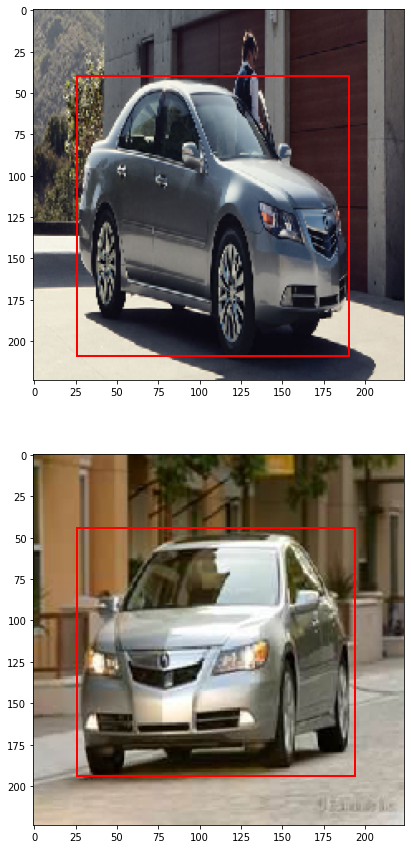

time: 562 ms (started: 2021-12-10 13:30:45 +00:00)


In [357]:
drawBoundingBoxesOnResizedImages(df_train_224.head(2),'image_array','xmin_scaled','ymin_scaled','xmax_scaled','ymax_scaled',2,'r')

#**Work In Progress**

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")
#sns.histplot(x= trainMergedImageDF['Image class'],bins = 20)

https://machinelearningmastery.com/use-pre-trained-vgg-model-classify-objects-photographs/

In [18]:
model_vgg16 = VGG16()

In [38]:
print(model_vgg16.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [43]:
model_vgg16_base = VGG16(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, weights="imagenet")

In [44]:
model_vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [48]:
# Classification layers
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(5, activation='softmax')

model_vgg16_final = models.Sequential([
    model_vgg16_base,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model_vgg16_final.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

model.fit(train_ds, train_labels, epochs=50, validation_split=0.2, batch_size=32, callbacks=[es])
